In [2]:
path = "/Users/karl/Documents/Workspace/415/Assignment 5/"


dog_image_path = path + 'Part 1/Dog.jpg'
person_image_path = path + 'Part 1/Person.jpg'


path_q2 = path + 'Part 2/'


# Part 1 - K-Means and Mean-Shift Clustering for Segmentation

## 1.1 - Compute the features

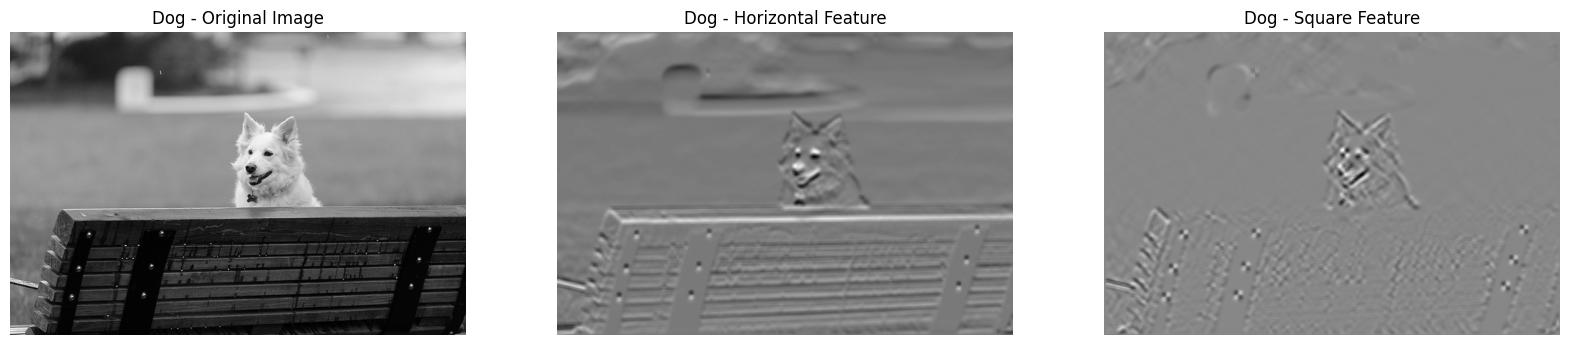

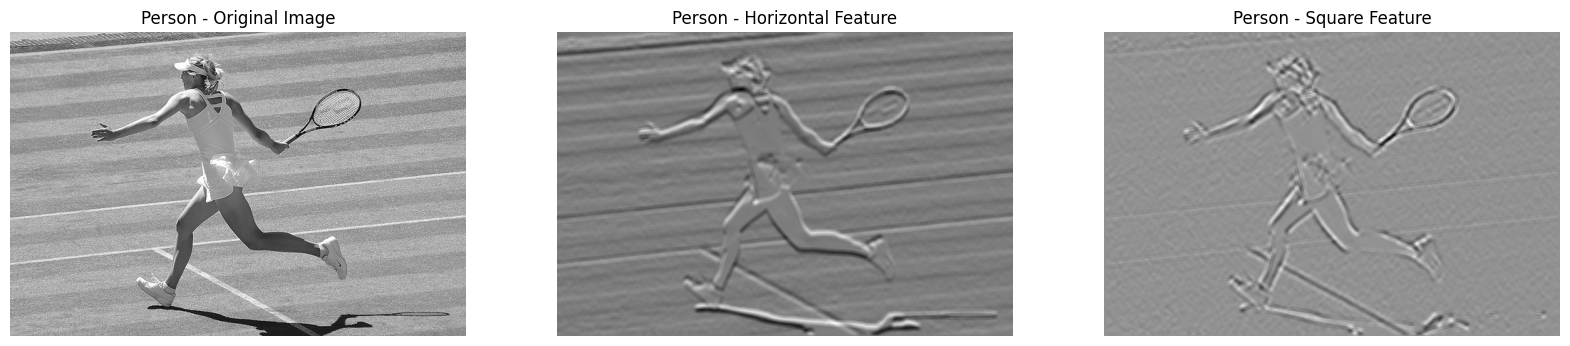

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Haar Filters
Haar_a1 = np.ones(shape=(12,6)) 
Haar_a1[6:12,:] = -1

Haar_b = np.ones(shape=(12,12))
Haar_b[:6,:6] = -1
Haar_b[6:12,6:12] = -1
# Reading and converting images
dog_img = cv2.imread(dog_image_path)
pers_img = cv2.imread(person_image_path)
dog_img_g = cv2.cvtColor(dog_img, cv2.COLOR_BGR2GRAY)
pers_img_g = cv2.cvtColor(pers_img, cv2.COLOR_BGR2GRAY)

# Applying Haar filters to extract features
dog_img_features_horizontal = cv2.filter2D(dog_img_g, cv2.CV_16S, Haar_a1)
dog_img_features_square = cv2.filter2D(dog_img_g, cv2.CV_16S, Haar_b)
pers_img_features_horizontal = cv2.filter2D(pers_img_g, cv2.CV_16S, Haar_a1)
pers_img_features_square = cv2.filter2D(pers_img_g, cv2.CV_16S, Haar_b)

# Function to plot images
def plot_images(img_path, feature_horizontal, feature_square, title):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(feature_horizontal, cmap='gray')
    plt.title(f'{title} - Horizontal Feature')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(feature_square, cmap='gray')
    plt.title(f'{title} - Square Feature')
    plt.axis('off')

    plt.show()


# Plotting for dog and person images
plot_images(dog_image_path, dog_img_features_horizontal, dog_img_features_square, 'Dog')
plot_images(person_image_path, pers_img_features_horizontal, pers_img_features_square, 'Person')

## 1.2 - K-means clustering

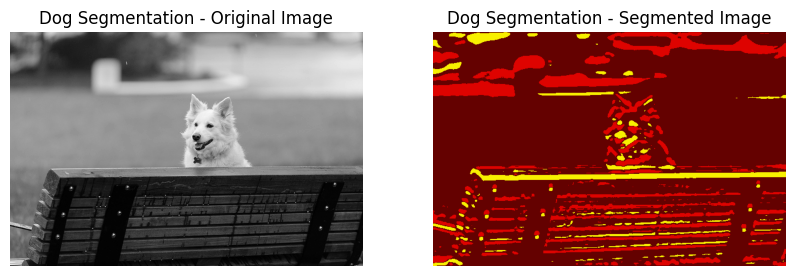

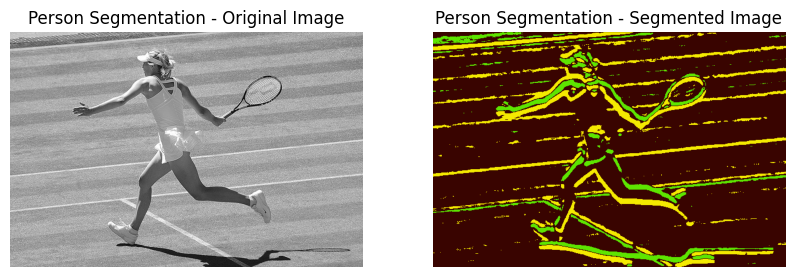

In [4]:
def segment_images_with_kmeans(horizontal_feature, square_feature, num_clusters=3):
    """Segment images based on horizontal and square features using k-means."""
    # Combine the horizontal and square features
    combined_features = np.stack((horizontal_feature, square_feature), axis=2)
    combined_features_flat = combined_features.reshape(-1, 2).astype('float32')

    # Define the criteria for k-means segmentation
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(combined_features_flat, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Mapping the centers to create the segmented image
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape(horizontal_feature.shape + (2,))

    # Create a displayable segmented image
    segmented_display = cv2.merge([segmented_image[:, :, 0], segmented_image[:, :, 1], np.zeros_like(segmented_image[:, :, 0])])

    return segmented_display

# Perform k-means segmentation on the features extracted from the images
segmented_dog_img = segment_images_with_kmeans(dog_img_features_horizontal, dog_img_features_square)
segmented_person_img = segment_images_with_kmeans(pers_img_features_horizontal, pers_img_features_square)

def plot_segmented_images(original_img_path, segmented_img, title):
    original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    # Plot segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f'{title} - Segmented Image')
    plt.axis('off')

    plt.show()


plot_segmented_images(dog_image_path, segmented_dog_img, 'Dog Segmentation')
plot_segmented_images(person_image_path, segmented_person_img, 'Person Segmentation')

## 1.3 - Mean-shift clustering

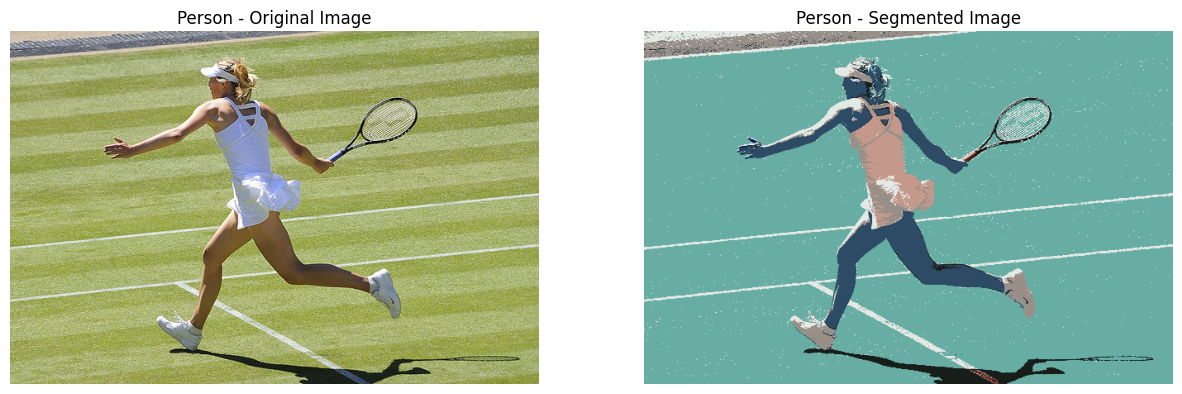

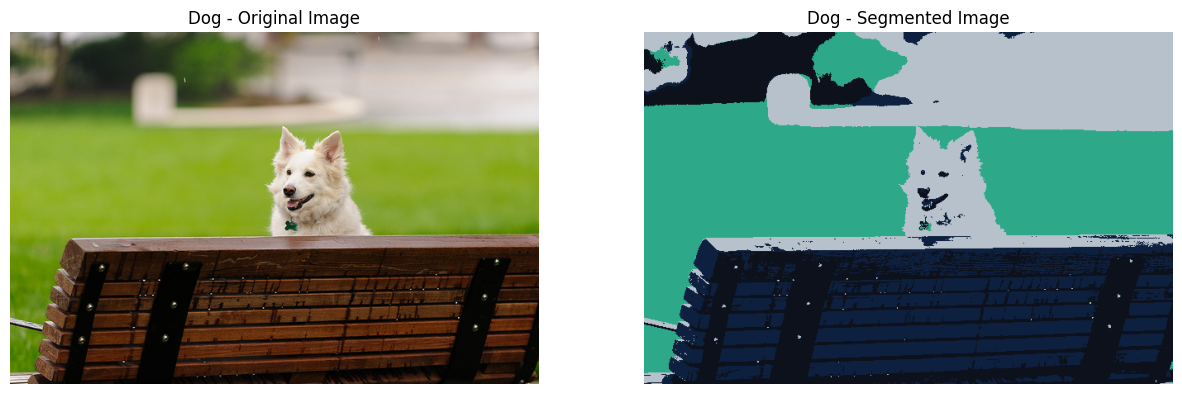

In [5]:
from skimage import io
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import MeanShift, estimate_bandwidth


def mean_shift_segmentation(image_lab):
    # Reshape the image to a two-column array of LAB color values
    flat_image_lab = image_lab.reshape((-1, 3))
    # Estimate bandwidth for MeanShift algorithm
    bandwidth = estimate_bandwidth(flat_image_lab, quantile=0.2, n_samples=500)
    # Perform MeanShift Clustering
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_image_lab)
    # Retrieve the labels and the cluster centers
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    # Assign each pixel the color of its cluster center
    segmented_image = cluster_centers[labels]
    segmented_image_lab = segmented_image.reshape(image_lab.shape)
    # Convert the segmented image from LAB back to RGB for displaying
    segmented_image_rgb = lab2rgb(segmented_image_lab.astype('float64'))
    return segmented_image_rgb

def plot_segmented_images(original_img_path, segmented_img, title):
    original_img = cv2.imread(original_img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    plt.figure(figsize=(15, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f'{title} - Original Image')
    plt.axis('off')
    
    # Plot segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f'{title} - Segmented Image')
    plt.axis('off')
    
    plt.show()


# Load and transform the image to the LAB color space
person_image_lab = rgb2lab(pers_img)

dog_image_lab = rgb2lab(dog_img)

# Perform MeanShift clustering
segmented_person_image = mean_shift_segmentation(person_image_lab)
segmented_dog_image = mean_shift_segmentation(dog_image_lab)

# Plot the segmented images using the provided function
plot_segmented_images(person_image_path, segmented_person_image, 'Person')
plot_segmented_images(dog_image_path, segmented_dog_image, 'Dog')


## 1.4 - Benefits and Limitations

## K-Means Clustering
### Benefits:
- **Efficiency**: K-Means is computationally efficient, especially for a small number of clusters and on large datasets.
- **Simplicity**: The algorithm is straightforward to implement and understand.
- **Scalability**: It scales well to large numbers of samples and has been successfully used in various applications.
- **Adaptability**: It can work with various types of features and distances.

### Limitations:
- **Number of Clusters**: The number of clusters (k) needs to be specified beforehand, which is not always evident from the data.
- **Sensitivity to Initialization**: The final results can be sensitive to the initial placement of the centroids. Random initialization can lead to poor convergence and require multiple runs.
- **Assumption of Spherical Clusters**: K-Means assumes that clusters are spherical and equally sized, which may not always be true for real-world data.
- **Noise and Outliers**: K-Means is sensitive to noise and outliers as they can significantly influence the mean calculation.

## Mean Shift Clustering
### Benefits:
- **Not Required to Specify Cluster Number**: Unlike K-Means, Mean Shift does not require the number of clusters to be specified in advance.
- **Robust to Initialization**: The algorithm is less sensitive to the initial conditions compared to K-Means.
- **Can Detect Arbitrary Shaped Clusters**: Mean Shift does not assume any prior cluster shape and can handle complex cluster shapes and sizes.
- **Mode Seeking**: It seeks the mode of clusters which can be an advantage when dealing with clusters of variable density.

### Limitations:
- **Computationally Expensive**: Mean Shift is more computationally intensive than K-Means, especially with a large number of features or high dimensionality.
- **Bandwidth Selection**: The choice of bandwidth is crucial and can dramatically influence the results. Selecting an appropriate bandwidth can be challenging.
- **Slower Convergence**: Mean Shift may take longer to converge, especially for data with many dimensions (curse of dimensionality).
- **Handling of Flat Structures**: It can merge distinct clusters or fail to converge on flat regions of the density function.


# Part 2 - Neural Network Implementation for Image Segmentation

## 2.1, 2.2 - Mask R-CNN and YOLOv8n-seg model

/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



image 1/1 /Users/karl/Documents/Workspace/415/Assignment 5/Part 2/000000000552.jpg: 448x640 1 person, 1 tennis racket, 43.5ms
Speed: 1.1ms preprocess, 43.5ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict2


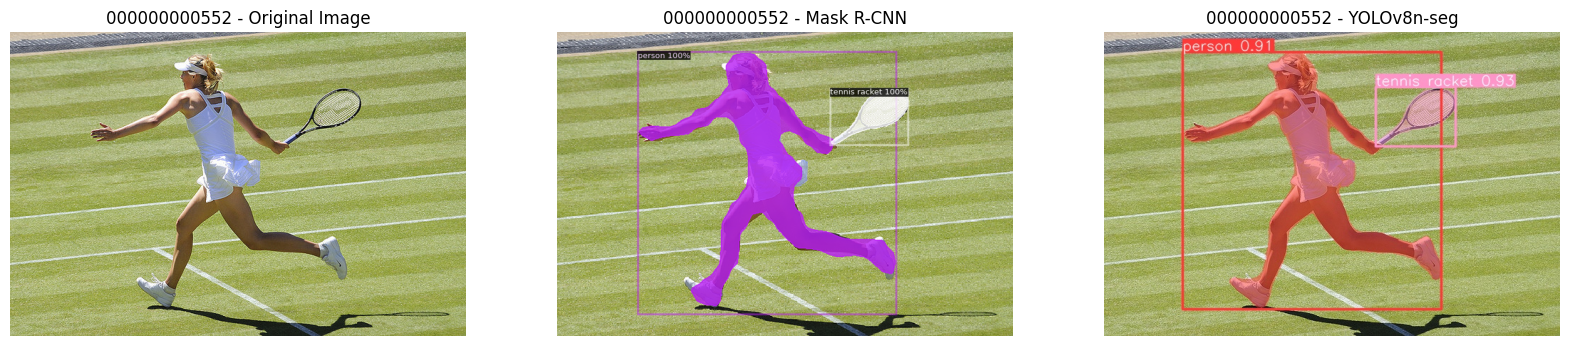


image 1/1 /Users/karl/Documents/Workspace/415/Assignment 5/Part 2/000000007226.jpg: 448x640 3 persons, 2 motorcycles, 1 truck, 50.7ms
Speed: 0.6ms preprocess, 50.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict2


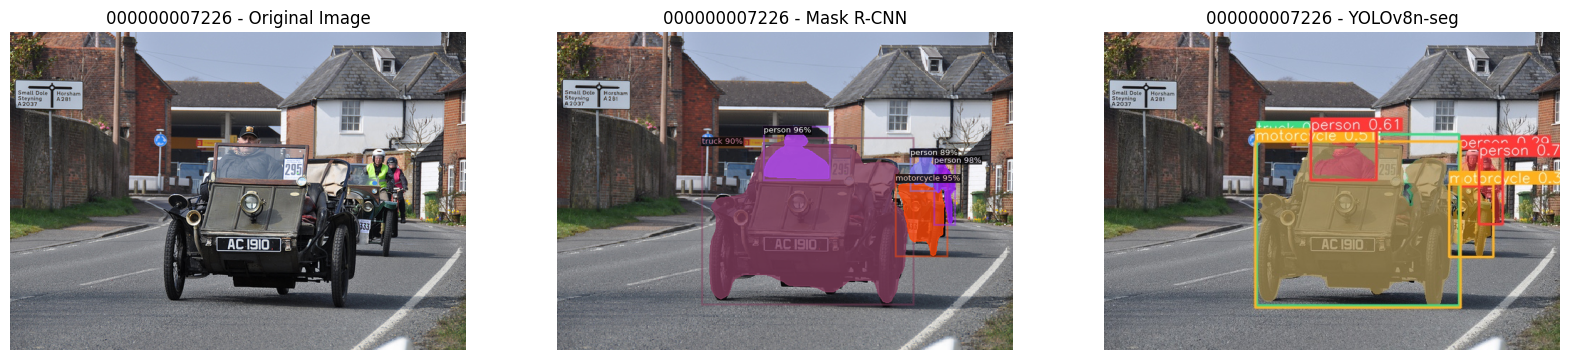

In [6]:
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import torch
from ultralytics import YOLO 


def display_images(original_img, mask_rcnn_output, yolov8_output, title):

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_rcnn_output)
    plt.title(f'{title} - Mask R-CNN')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(yolov8_output)
    plt.title(f'{title} - YOLOv8n-seg')
    plt.axis('off')

    plt.show()


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = 'cpu'  
predictor = DefaultPredictor(cfg)

yolo_model = YOLO('yolov8n-seg.pt')


for image_file in ['000000000552.jpg', '000000007226.jpg']:
    image_path = path_q2 + image_file

    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    original_img_tensor = torch.from_numpy(original_img_rgb).to('cpu')

    # Mask R-CNN inference
    mask_rcnn_outputs = predictor(original_img)
    v = Visualizer(original_img_rgb[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.SEGMENTATION)
    mask_rcnn_vis = v.draw_instance_predictions(mask_rcnn_outputs["instances"].to('cpu')).get_image()[:, :, ::-1]

    # YOLOv8n-seg inference
    yolo_results = yolo_model(image_path, save=True)
    yolo_image_path = f'./runs/segment/predict/{image_file}'
    yolo_result = cv2.imread(yolo_image_path)
    yolo_result_rgb = cv2.cvtColor(yolo_result, cv2.COLOR_BGR2RGB)

    # Display the images
    display_images(original_img_rgb, mask_rcnn_vis, yolo_result_rgb, image_file.split('.')[0])


## 2.3 - Montreal street 


image 1/1 /Users/karl/Documents/Workspace/415/Assignment 5/mtl_street.png: 480x640 4 persons, 5 cars, 1 bus, 1 truck, 43.1ms
Speed: 1.6ms preprocess, 43.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


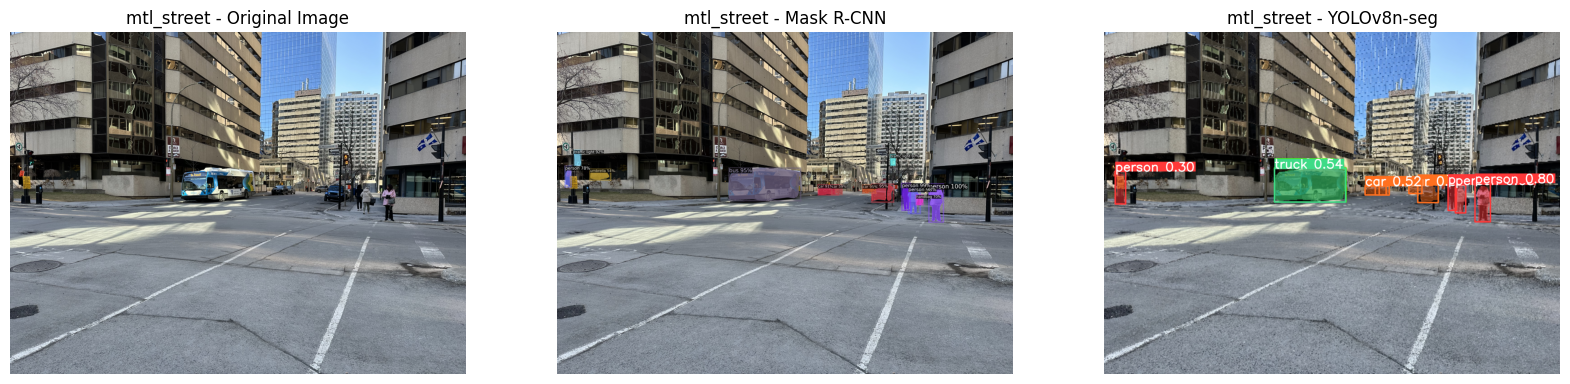

In [7]:
image_path = path + '/mtl_street.png'
image_file = 'mtl_street.png'

original_img = cv2.imread(image_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

original_img_tensor = torch.from_numpy(original_img_rgb).to('cpu')

# Mask R-CNN inference
mask_rcnn_outputs = predictor(original_img)
v = Visualizer(original_img_rgb[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.SEGMENTATION)
mask_rcnn_vis = v.draw_instance_predictions(mask_rcnn_outputs["instances"].to('cpu')).get_image()[:, :, ::-1]

# YOLOv8n-seg inference
yolo_results = yolo_model(image_path, save=True)
yolo_image_path = f'./runs/segment/predict/{image_file}'
yolo_result = cv2.imread(yolo_image_path)
yolo_result_rgb = cv2.cvtColor(yolo_result, cv2.COLOR_BGR2RGB)

# Display the images
display_images(original_img_rgb, mask_rcnn_vis, yolo_result_rgb, image_file.split('.')[0])    

## 2.4 - Performance Comparison


- **Mask R-CNN** appears to have better instance segmentation capabilities, as indicated by the higher confidence scores and more precise segmentation masks that delineate the contours of detected objects, such as vehicles and individuals.
  
- **YOLOv8n-seg**, while highly efficient and fast, shows a slightly lower confidence in object detection and generally provides bounding boxes without instance-level segmentation.

### Performance Metrics

- **Confidence Scores**:
  - In the tennis image, YOLO gave a 91% confidence score for the person and 93% for the tennis racket, while Mask R-CNN provided a perfect score of 100% for both.
  - In the car image, YOLO presented multiple bounding boxes for the same objects with varying confidence scores, whereas Mask R-CNN depicted single bounding boxes with high confidence and also provided segmentation masks.

- **Accuracy**:
  - Mask R-CNN demonstrates higher accuracy with segmentation masks that closely follow the object boundaries.
  - YOLO focuses on speed and real-time detection, which may result in slightly less accuracy, particularly in instance segmentation tasks.

### Steps Taken by Mask R-CNN to Achieve Final Results

1. **Backbone Network**: Mask R-CNN begins with a backbone network to extract a set of feature maps from the image.
2. **Region Proposal Network (RPN)**: From the feature maps, the RPN proposes candidate object bounding boxes.
3. **RoI Pooling**: Regions of Interest (RoIs) are then extracted and pooled to a fixed size.
4. **Branches for Classification, Bounding Box Regression, and Mask Prediction**:
    - The classification branch predicts the class of each RoI.
    - The bounding box regression branch fine-tunes the bounding box coordinates.
    - The mask prediction branch generates a segmentation mask for each RoI at the pixel level, which is key for instance segmentation.
5. **Combining Predictions**: Finally, the model combines these predictions to output the class, bounding box, and mask for each detected instance in the image.

### Conclusion

- For applications that require real-time processing and can compromise slightly on accuracy, YOLOv8n-seg is an excellent choice due to its speed.
- When high accuracy and instance-level detail are paramount, especially in scenarios where precise object outlines are necessary, Mask R-CNN outperforms YOLO, as it provides detailed segmentation masks along with the detection boxes.

Both models serve different purposes and excel in different aspects of object detection and segmentation tasks.
